## Final project for 02806: Analysis of pedestrian counts in Melbourne of year 2019

In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
from joblib import dump, load
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime

import folium
import json

import plotly
import plotly.express as px
import plotly.graph_objects as go

In [35]:
folderPath = 'data/' #/content/drive/MyDrive/social data analysis and visualization

In [31]:
pedestrian_counts = 'Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv'
sensors_location = 'Pedestrian_Counting_System_-_Sensor_Locations.csv'

### 1. Motivation
**What is your dataset?** 

1. Information about pedestrian counts counted by the sensors in Melbourne per hour, [link](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp?src=featured_banner).
2. Information about the sensors, [link](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234).
3. Melbourne weather data, [link](https://www.wunderground.com/history/daily/YMML/date/2019-1-1).


In [11]:
# 1. Information about pedestrian counts counted by the sensors in Melbourne per hour
df1 = pd.read_csv(pedestrian_counts)
df1.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,36,Queen St (West),774


In [13]:
# 2. Information about the sensors
df2 = pd.read_csv(sensors_location)
df2.head()

,sensor_id,sensor_description,sensor_name,installation_date,status,note,direction_1,direction_2,latitude,longitude,location
0,55,Elizabeth St-La Trobe St (East),Eli380_T,2018/07/19,A,NaN,North,South,-37.809889,144.961343,"(-37.80988941, 144.96134331)"
1,45,Little Collins St-Swanston St (East),Swa148_T,2017/06/29,A,NaN,North,South,-37.814141,144.966094,"(-37.81414074, 144.9660938)"
2,61,RMIT Building 14,RMIT14_T,2019/06/28,A,NaN,North,South,-37.807675,144.963091,"(-37.80767455, 144.96309115)"
3,7,Birrarung Marr,Fed_T,2014/12/17,A,NaN,East,West,-37.818629,144.971694,"(-37.81862929, 144.97169395)"
4,72,Flinders St- ACMI,ACMI_T,2020/11/30,A,NaN,East,West,-37.817263,144.968728,"(-37.81726337, 144.96872809)"


**Why did you choose this/these particular dataset(s)?**

The datasets are official, they contain the proper number of attributes with acceptable sizes, their data type and format are also handy for analysis, and they are appropriate for machine learning.

**What was your goal for the end user's experience?**

Users can feel the changes of pedestrian count by selecting the time and sensor ID. And they can freely choose the machine learning models to predict pedestrian tendency during the user-defined time period.

### 2. Basic stats. Let's understand the dataset better
**Write about your choices in data cleaning and preprocessing.**

**Cleaning:**

For columns, we select **_Hourly Counts, latitude, longitude, sensor name, sensor ID and Time related columns_**, and delete **_ID, sensor description, installnation date, status, note, and directions related_** columns since they are irrelevant to our task.

For rows, we selected objects from **_January 1, 2019 to December 31, 2019_**, since the 2019 is average and close to us.

In [14]:
df2.rename(columns={'sensor_id':'Sensor_ID'}, inplace=True)
df = df1.merge(df2, on=['Sensor_ID'], how='inner')
df = df[['Year', 'Month', 'Mdate', 'Day', 'Time', 'Sensor_ID', 'Sensor_Name', 'Hourly_Counts', 'latitude', 'longitude']]
df = df[df['Year'].isin(['2019'])]; df = df.dropna()
mapping_M = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
       'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
df.Month = df.Month.map(mapping_M)
mapping_W = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Day = df.Day.map(mapping_W)
N, M = np.shape(df)
print('There are %s samples and %s attributes in our dataset'%(N,M), '\n')
print('Here is a piece of our dataset: ')
df.head()

There are 456829 samples and 10 attributes in our dataset 

Here is a piece of our dataset: 


,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts,latitude,longitude
0,2019,11,1,5,17,34,Flinders St-Spark La,300,-37.81538,144.97415
1,2019,11,1,5,18,34,Flinders St-Spark La,240,-37.81538,144.97415
2,2019,11,1,5,19,34,Flinders St-Spark La,158,-37.81538,144.97415
3,2019,11,1,5,20,34,Flinders St-Spark La,118,-37.81538,144.97415
4,2019,11,1,5,21,34,Flinders St-Spark La,131,-37.81538,144.97415


In [17]:
df.to_csv('final_data.csv')

**Preprocessing:**

In this step, we find that selecting a particular row of data is time-consuming since we have to set multiple indexes of the data. To solve this problem, we decided to use the hours of the whole year as the index. Starting from 00:00 Jan 1st, 2019 as the starting hour and end up with 23:00 Dec 31, 2019.


In [18]:
df = df.set_index(['Year', 'Month', 'Mdate', 'Time'])
df.head()

Day  Sensor_ID           Sensor_Name  Hourly_Counts  \
Year Month Mdate Time                                                        
2019 11    1     17      5         34  Flinders St-Spark La            300   
                 18      5         34  Flinders St-Spark La            240   
                 19      5         34  Flinders St-Spark La            158   
                 20      5         34  Flinders St-Spark La            118   
                 21      5         34  Flinders St-Spark La            131   

                       latitude  longitude  
Year Month Mdate Time                       
2019 11    1     17   -37.81538  144.97415  
                 18   -37.81538  144.97415  
                 19   -37.81538  144.97415  
                 20   -37.81538  144.97415  
                 21   -37.81538  144.97415

In [19]:
df.reset_index(inplace=True)
standard = datetime(2019,1,1,0)
Yhours = []
for i in range(len(df.index)):
    Y = df['Year'][i]
    M = df['Month'][i]
    D = df['Mdate'][i]
    T = df['Time'][i]
    cur = datetime(Y, M, D, T)
    diff = cur - standard
    diff = diff.total_seconds()
    if diff % 3600 == 0:
        diff = diff//3600
    Yhours.append(diff)
df['Yhours'] = Yhours
df.head()

,Year,Month,Mdate,Time,Day,Sensor_ID,Sensor_Name,Hourly_Counts,latitude,longitude,Yhours
0,2019,11,1,17,5,34,Flinders St-Spark La,300,-37.81538,144.97415,7313.0
1,2019,11,1,18,5,34,Flinders St-Spark La,240,-37.81538,144.97415,7314.0
2,2019,11,1,19,5,34,Flinders St-Spark La,158,-37.81538,144.97415,7315.0
3,2019,11,1,20,5,34,Flinders St-Spark La,118,-37.81538,144.97415,7316.0
4,2019,11,1,21,5,34,Flinders St-Spark La,131,-37.81538,144.97415,7317.0


**Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.**


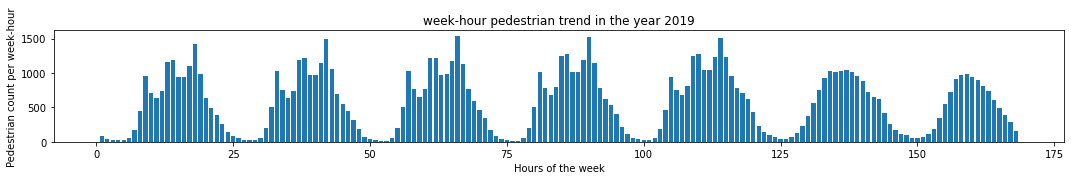

In [20]:
modes_weekhour = list(df.groupby(['Day', 'Time'])['Hourly_Counts'].mean())#agg(lambda x:x.value_counts().index[0])
#modes_week = list(df.groupby(['Month'])['Hourly_Counts'].mean())#agg(lambda x:x.value_counts().index[0])
plt.figure(figsize=(15,2.5))
plt.subplot(1,1,1)
plt.bar(range(1,169), modes_weekhour)
plt.xlabel('Hours of the week'); plt.ylabel('Pedestrian count per week-hour'); plt.title('week-hour pedestrian trend in the year 2019')
plt.tight_layout()
plt.show()

In weekdays, we can observe clear rush hours while in weekends the trend changes smoothly.

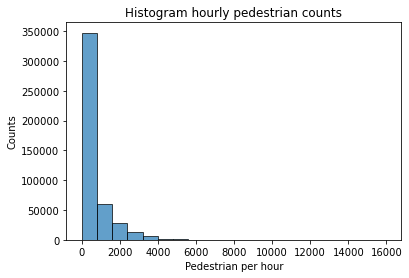

In [21]:
count, bins = np.histogram(df.Hourly_Counts, bins=20)
plt.hist(df.Hourly_Counts, bins=bins, alpha=0.7, edgecolor='black')
#plt.yticks(np.arange(0, 300, 50))
plt.xlabel('Pedestrian per hour'); plt.ylabel('Counts'); plt.title('Histogram hourly pedestrian counts')
plt.show()

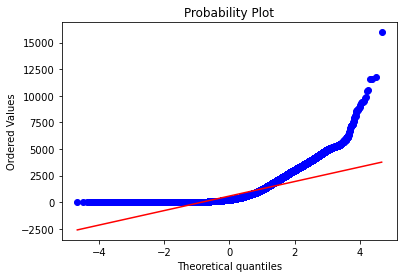

In [22]:
from scipy import stats
stats.probplot(df.Hourly_Counts, plot=plt); plt.show()

The histogram and probability plot above show the hourly counts don't follow a normal distribution. Latter we will talk about its extreme values, the count which is more than 10000.

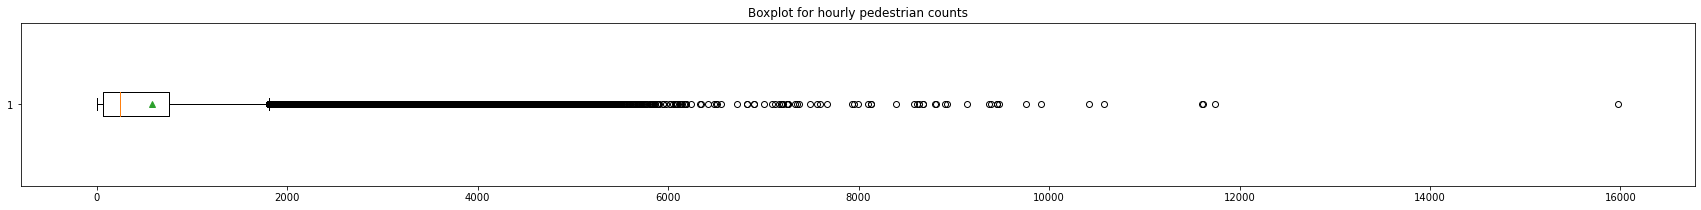

In [23]:
plt.figure(figsize=(30,3))
plt.boxplot(df.Hourly_Counts, vert=False, showmeans=True)
plt.title('Boxplot for hourly pedestrian counts')
plt.show()

We extract the counts which greater than 10000, and find out they focus on two areas Bourke St Bridge and Birrarung Marr.

In [24]:
df[df.Hourly_Counts>=10000]

,Year,Month,Mdate,Time,Day,Sensor_ID,Sensor_Name,Hourly_Counts,latitude,longitude,Yhours
171220,2019,11,15,23,5,57,Bourke St Bridge,15979,-37.817673,144.950256,7655.0
176767,2019,12,18,17,3,57,Bourke St Bridge,11612,-37.817673,144.950256,8441.0
177768,2019,8,22,18,4,57,Bourke St Bridge,10422,-37.817673,144.950256,5610.0
177814,2019,8,24,16,6,57,Bourke St Bridge,11605,-37.817673,144.950256,5656.0
318594,2019,8,23,22,5,7,Birrarung Marr,11742,-37.818629,144.971694,5638.0
318616,2019,8,24,20,6,7,Birrarung Marr,10576,-37.818629,144.971694,5660.0


In [25]:
df2['Year'] = pd.to_datetime(df2['installation_date']).dt.year
df2 = df2[df2['Year'].isin(range(2000, 2020))]

lat = np.array(df2.latitude)
lon = np.array(df2.longitude)

map_SF = folium.Map(location=[-37.8136, 144.9631], zoom_start = 14)
for i in range(len(df2.index)):
  folium.Marker(['%.4f'%lat[i], '%.4f'%lon[i]], icon=folium.Icon(color='red')).add_to(map_SF)
map_SF

### 3. Data Analysis
**Describe your data analysis and explain what you've learned about the dataset.**

1. Outliers, we define the counts which are **more than 10000 as outliers**.

    We search the location and the time on the Internet, and find the below events that may relevant to our observation:
    
    Bourke St Bridge: 
    
    1. 08/22/2019 - 08/24/2019 The USA Basketball Men's National Team VS. the Australian Boomers, [link](https://marvelstadium.com.au/boomers_v_usabasketball/). 
    
    2. 11/15/2019 U2: The Joshua Tree Tour 2019 , [link](https://marvelstadium.com.au/event/u2-2019/).

  Birrarung Marr: 08/23/2019 - 08/24/2019 White Night 2019, [link](https://www.heraldsun.com.au/entertainment/everything-you-need-to-know-about-melbournes-white-night-reimagined-2019/news-story/03dac4da52cb51c0f3583fa36bd2c321)

2. Trend

    During the day (00:00-23:59), people come out of their house at around 7 and they begin to come home or hang out to have some relax at around 18.

    During the week (Monday-Sunday), we observe the data hourly and we find that the city leads a predictable schedule during the whole week. In weekdays, we can observe clear rush hours while in weekends the trend changes smoothly.

    During the month (January-December), the pedestrian flow is not season sensible.

**If relevant, talk about your machine-learning.**

We want to use the machine learning method to _**hourly pedestrian counts in Melbourne**_. Basically, we use the linear regression to tackle this job. Since sensors’ id cannot be counted as one feature, we use the one-hot method to parse the id.

_**For our first model, the input attributes are Month(1-12), Date(1-31), Time(0-23), Weekday(1-7) and sensor ID(one-hot)**_

In [26]:
oneHot = pd.get_dummies(df, columns=['Sensor_ID'], prefix = ['id'],drop_first=False)
oneHot = oneHot.dropna()
oneHot.drop(['Year'
             , 'Sensor_Name'
             , 'latitude'
             , 'longitude'
             , 'Yhours'
            ]
            , axis=1
            ,inplace=True)
oneHot.head()

,Month,Mdate,Time,Day,Hourly_Counts,id_1,id_2,id_3,id_4,id_5,...,id_53,id_54,id_55,id_56,id_57,id_58,id_59,id_60,id_61,id_62
0,11,1,17,5,300,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,1,18,5,240,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,1,19,5,158,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,1,20,5,118,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,1,21,5,131,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X1= oneHot.loc[:,oneHot.columns !='Hourly_Counts']
Y1 = oneHot['Hourly_Counts']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.20, random_state=42)
reg1 = LinearRegression().fit(x_train1, y_train1)
reg1.score(x_train1, y_train1) #R square matrix

0.3916671811203012

In [36]:
dump(reg1,folderPath+'data.pkl')

['data/data.pkl']

In [ ]:
X2 = sm.add_constant(x_train1)
est = sm.OLS(y_train1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          Hourly_Counts   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     3857.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        02:33:26   Log-Likelihood:            -2.8734e+06
No. Observations:              365463   AIC:                         5.747e+06
Df Residuals:                  365401   BIC:                         5.748e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        286.1186      3.983     71.843      0.0

**The result of this method is quite bad with only 0.391 of R-squared value.**
 


_**In our second model, we add weather related attributes(Temperature, Humidity, Wind Direction, Wind Speed, Pressure, Condition, UV) based on model 1**_

In [37]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_weather = pd.DataFrame()
for i in month:
    df_weather = df_weather.append(pd.read_excel('weather_data/{}.xls'.format(i)), ignore_index=True)

In [38]:
# Convert Fahrenheit to Centigrade
df_weather['Temperature'] = 5*(df_weather['Temperature']-32)//9

In [39]:
time = df_weather['Time'].values
standard = datetime(2019,1,1,0)
yhour = []
for i in range(len(time)):
    cur = datetime.fromtimestamp(time[i])
    diff = cur - standard
    diff = diff.total_seconds()
    if diff % 3600 == 0:
        diff = diff//3600
    yhour.append(diff)
df_weather['Time'] = np.array(yhour)
df_weather = df_weather.rename(columns={'Time':'Yhours'})

In [40]:
df_final = df.merge(df_weather, on=['Yhours'],how='left')
df_final.head()

,Year,Month,Mdate,Time,Day,Sensor_ID,Sensor_Name,Hourly_Counts,latitude,longitude,Yhours,Temperature,Humidity,Wind_direction,Wind_speed,Pressure,Condition,UV
0,2019,11,1,17,5,34,Flinders St-Spark La,300,-37.81538,144.97415,7313.0,18.0,68.0,S,10.0,29.21,Mostly Cloudy,Low
1,2019,11,1,18,5,34,Flinders St-Spark La,240,-37.81538,144.97415,7314.0,16.0,82.0,SW,22.0,29.33,Light Rain Shower / Windy,Low
2,2019,11,1,19,5,34,Flinders St-Spark La,158,-37.81538,144.97415,7315.0,15.0,94.0,SSW,13.0,29.33,Light Rain Shower,Low
3,2019,11,1,20,5,34,Flinders St-Spark La,118,-37.81538,144.97415,7316.0,15.0,94.0,S,3.0,29.36,Light Rain Shower,Low
4,2019,11,1,21,5,34,Flinders St-Spark La,131,-37.81538,144.97415,7317.0,15.0,94.0,ENE,10.0,29.33,Rain Shower,Low


In [41]:
oneHot = pd.get_dummies(df_final, columns=['Sensor_ID','Condition','UV'], prefix = ['id','weather','uv'],drop_first=False)
oneHot = oneHot.dropna()
oneHot.drop(['Year'
             , 'Sensor_Name'
             , 'latitude'
             , 'longitude'
             ,'Yhours'
             ,'Wind_direction'
            ]
            , axis=1
            ,inplace=True)

In [42]:
X1= oneHot.loc[:,oneHot.columns !='Hourly_Counts']
Y1 = oneHot['Hourly_Counts']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.20, random_state=42)
reg1 = LinearRegression().fit(x_train1, y_train1)
reg1.score(x_train1, y_train1) 

0.4139733471464704

In [43]:
X2 = sm.add_constant(x_train1)
est = sm.OLS(y_train1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          Hourly_Counts   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     2571.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        18:56:35   Log-Likelihood:            -2.8549e+06
No. Observations:              364014   AIC:                         5.710e+06
Df Residuals:                  363913   BIC:                         5.711e+06
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Our new model’s evaluation **has been improved but not much(R-squared value is 0.419)**. This evaluation indicates that weather in Melbourne contributes to our prediction model. But we still need to find the most important part of our machine learning puzzle. 
_**In our last model, we note that people’s flow is time-related, so we use the previous data from 1 hour and 2 hours as two of our new features.**_

In [44]:
df_WeatherandPrevious = pd.DataFrame()
test = df_final.groupby('Sensor_ID').indices
for i in test.keys():
    df_temp = df_final.iloc[test[i]].sort_values('Yhours')
    df_temp['previous1'] = df_temp['Hourly_Counts'].shift(1, fill_value=0)
    df_temp['previous2'] = df_temp['Hourly_Counts'].shift(2, fill_value=0)
    df_WeatherandPrevious = df_WeatherandPrevious.append(df_temp, ignore_index=True)
df_WeatherandPrevious.head()

,Year,Month,Mdate,Time,Day,Sensor_ID,Sensor_Name,Hourly_Counts,latitude,longitude,Yhours,Temperature,Humidity,Wind_direction,Wind_speed,Pressure,Condition,UV,previous1,previous2
0,2019,1,1,0,2,1,Bourke Street Mall (North),918,-37.813494,144.965153,0.0,16.0,82.0,WSW,6.0,29.42,Mostly Cloudy,Low,0,0
1,2019,1,1,1,2,1,Bourke Street Mall (North),995,-37.813494,144.965153,1.0,17.0,77.0,SW,5.0,29.42,Mostly Cloudy,Low,918,0
2,2019,1,1,2,2,1,Bourke Street Mall (North),416,-37.813494,144.965153,2.0,20.0,73.0,S,7.0,29.42,Fair,Moderate,995,918
3,2019,1,1,3,2,1,Bourke Street Mall (North),382,-37.813494,144.965153,3.0,21.0,64.0,SSW,7.0,29.42,Fair,High,416,995
4,2019,1,1,4,2,1,Bourke Street Mall (North),165,-37.813494,144.965153,4.0,22.0,53.0,SSE,6.0,29.39,Fair,Very High,382,416


In [45]:
df_WeatherandPrevious.to_csv(folderPath+'finalWithPreviousCountsandWeather.csv')

In [46]:
oneHot = pd.get_dummies(df_WeatherandPrevious, columns=['Sensor_ID','Condition','UV'], prefix = ['id','weather','uv'],drop_first=False)
oneHot = oneHot.dropna()
oneHot.drop(['Year'
             , 'Sensor_Name'
             , 'latitude'
             , 'longitude'
             ,'Yhours'
             ,'Wind_direction'
            ]
            , axis=1
            ,inplace=True)

In [47]:
X1= oneHot.loc[:,oneHot.columns !='Hourly_Counts']
Y1 = oneHot['Hourly_Counts']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.20, random_state=42)
reg1 = LinearRegression().fit(x_train1, y_train1)
reg1.score(x_train1, y_train1) #R square

0.8364717427876646

In [48]:
X2 = sm.add_constant(x_train1)
est = sm.OLS(y_train1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          Hourly_Counts   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.825e+04
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        18:57:38   Log-Likelihood:            -2.6225e+06
No. Observations:              364014   AIC:                         5.245e+06
Df Residuals:                  363911   BIC:                         5.246e+06
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

_**The evaluation of the latest model shows a huge improvement when comparing with the previous two models with 0.836 of R-squared value,**_

### 4. Genre.
**Which genre of data story did you use?**

We use annotated Graph and Map as our genre.

**Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**

1. Visual Structuring:

    1.1 Consistent visual/platform: the main color is blue for the outlook of our website.

    1.2 Time bar: histogram of the pedestrian counts allows users to explore data through time points

2. Highlighting:

    1.1 Zooming: The map can be zoomed in and out to show the number of pedestrians counted by the sensor in a specific area; The time point can be selected to observe the number of pedestrians counted by the sensor in a specific time range.

    1.2 Motion: The map uses the time bar to display the dynamic changes of the number of pedestrians over time.
    

**Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**
1. Random Access:

    Allow a more flexibility for user to explore.

2. Hover highlighting/details：

    For every sensor on the map, pop out the location and pedestrian count; For each bar, pop out the time and pedestrian count.

3. Filtering / Selection / Search:

    Filter the date or time, and select the sensor.

4. Messaging:

    Captions / Headings / Comment / Introductory text.

### 5. Visualizations.
**Explain the visualizations you've chosen.**

In explanatory part, we choose the annotated map, interactive bar chart and line chart. 

In exploratory part, we choose the bar chart, histogram chart, probability plot, box plot and folium map.

**Why are they right for the story you want to tell?**

In the explanatory part, the annotated map gives users an intuitive sense of the pedestrian flow, and the interactive bar chart shows a more precise tendency of the count, the combination of the line chart of predicted value and true value can clearly show the performance of our models.

In exploratory part, histogram, probability plot and boxplot are chosen because they can show the distribution of the data.

### 6. Discussion.
**What went well?**

We extracted the sensor data to reflect the actual pedestrian count in Melbourne city. We dynamically display the data of pedestrian flow through maps. We implement the Machine Learning method to predict the pedestrian flow, we combine the weather data and previous 2 hours counting data to improve the prediction result. 	

**What is still missing? What could be improved?, Why?**

We didn’t make full use of our dataset, for example the nearest four sensors counts are not used for machine learning. The platform that displays our results is not good enough, our website is not very attractive and user-friendly. The user interaction is not very smooth and interesting.


### 7. Contributions. Who did what?
**You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).**

**It is not OK simply to write "All group members contributed equally".**

1. Gong Zhao: Part of data processing and pre analysing. Web API for the map of sensor layout, the histogram of pedestrian counts, and the machine learning.

2. Ma Yun: Data cleaning, part of data processing and pre analysing and website.

3. Yu Yemu: Outliers detection and analysing, and part of machine learning.
